In [ ]:
# installing what we need for huggingface datasets and tools
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

***This first step is like going to the store to get our ingredients. We're installing the datasets library to easily download our text data and transformers to use efficient pre-trained models like DistilBERT.***

In [ ]:
# pulling in the hf dataset tool
from datasets import load_dataset

dataset = load_dataset("tdavidson/hate_speech_offensive")  # 24k examples, label 0/1/2 = hate/offensive/neither

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In this step, we loaded the “tdavidson/hate_speech_offensive” dataset by calling load_dataset(...). The line dataset = load_dataset("tdavidson/hate_speech_offensive") fetches and caches the tweets and their label field, giving us ready to use data for classification.

In [ ]:
print(dataset['train'][0])  # tweet text + label

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import class_weight

# extract texts and labels from the HF dataset
texts = dataset['train']['tweet']      # list of all tweets
labels = dataset['train']['class']     # list of labels (0/1/2)


train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels       # preserves label distribution apparently
)


unique_classes = np.unique(train_labels)
weights = class_weight.compute_class_weight(
    class_weight='balanced', # 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
    classes=unique_classes,
    y=train_labels
)
# Create a dictionary mapping class index to its weight
class_weights_dict = dict(zip(unique_classes, weights))

print(f"\nCalculated class weights: {class_weights_dict}")
print(f"Dataset has classes: {dataset['train'].features['class'].names}")
print(f"Our label map will be: 0: Hate Speech, 1: Offensive Language, 2: Neither (based on dataset features)")

{'count': 3, 'hate_speech_count': 0, 'offensive_language_count': 0, 'neither_count': 3, 'class': 2, 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}

Calculated class weights: {np.int64(0): np.float64(5.776806526806527), np.int64(1): np.float64(0.4304759423310752), np.int64(2): np.float64(1.9845845845845846)}
Dataset has classes: ['hate speech', 'offensive language', 'neither']
Our label map will be: 0: Hate Speech, 1: Offensive Language, 2: Neither (based on dataset features)


***We're splitting our data into a training set (for the model to learn from) and a validation set (to check how well it's learning). Crucially, we've added code to calculate class_weights. This helps our model pay more attention to the "hate speech" class, which is less common in the data, so it doesn't get ignored.***

In [ ]:
# bring in the tokenizer for distilbert
from transformers import DistilBertTokenizerFast  # hf tokenizer tool

# init tokenizer from pretrained weights
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")  # quick, lightweight and still performs as well as bert mostly

# tokenize our splits with uniform length
train_encodings = tokenizer(
    train_texts,
    truncation=True,            # chops longer tweets
    padding='max_length',       # pads shorter ones to max_length
    max_length=128              # cap sequences at 128 tokens
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=128
)

***We need to turn our text into numbers so we use tokenizer for this purpose. It converts tweets into sequences of numbers (tokens) and makes sure they're all the same length (128 here).***

In [ ]:
import tensorflow as tf

# wrap encodings & labels into a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)) # inputs + targets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

train_dataset = train_dataset.shuffle(1000).batch(16)  # shuffle and batch the training set, just batch the validation set
val_dataset = val_dataset.batch(16)

***Here we converted our tokenized inputs and labels into tf.data.Dataset objects and applied shuffle(1000) with batch(16) for the training split, ensuring randomized batches, and simply batched the validation split for consistent evaluation.***

In [ ]:
# bring in hf and tf
from transformers import TFDistilBertModel  # pretrained transformer
from tensorflow.keras import Model          # keras model assemble
from tensorflow.keras.layers import (
    Input,                                 # define inputs
    Lambda,                                # wrap for hf compatibility
    Dense,                                 # fully connected
    Dropout,                               # random unit drop
    BatchNormalization,                    # normalize activations
    LeakyReLU                             # Leaky ReLU activation
)
import tensorflow as tf                     # tf core
from tensorflow.keras.regularizers import l2

# load & freeze the pretrained base
base = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
base.trainable = False  # keep weights locked, we only train our custom head

# figure out hidden size for our pooled output
hidden_size = base.config.hidden_size  # usually 768

# define our two inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids") # 1D array of length 128
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask") #same here

# wrap hf model call so keras knows the output shape
# We take the embedding of the [CLS] token, which represents the whole sentence
pooled = Lambda(
    lambda ids_mask_tuple: base(input_ids=ids_mask_tuple[0], attention_mask=ids_mask_tuple[1])
                       .last_hidden_state[:, 0], # Use [CLS] token embedding
    output_shape=(hidden_size,)
)([input_ids, attention_mask]) # Pass inputs as a tuple


# layer 1- a bit wider to capture more features
x = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(pooled)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# layer 2- another layer for more complex patterns
x = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# layer 3- a smaller layer before the final decision, using 'swish' activation
x = Dense(32, activation="swish", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(3, activation="softmax")(x) # output layer is 3 units for 3 classes (hate, offensive, neither), softmax for probabilities


model = Model(inputs=[input_ids, attention_mask], outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy", # Good for multi-class integer labels (0/1/2)
    metrics=["accuracy"] # we will look at more detailed metrics after training
)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    196,864 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128)       │          0 │ dense_5[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │         99 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 235,651 (920.51 KB)

 Trainable params: 234,819 (917.26 KB)

 Non-trainable params: 832 (3.25 KB)

***Here i built the full model architecture by combining a frozen DistilBERT base with a custom classification head, which is pretty similar to what we did back in Week 5 when we froze VGG16 for image classification and just trained the dense layers we added on top.***

***I used TFDistilBertModel to extract features from the tweets, but I didn’t use the final output token predictions from the original model (jus
t like how we dropped VGG16’s top layer). I used a Lambda layer to grab the [CLS] token representation—the summary of each tweet—and passed that through my own head: a Dense → BatchNorm → Dropout → Softmax setup. Same structure as Week 5, just applied to text instead of images.***

***Freezing the base (base.trainable = False) is the same idea we did before: it lets us train faster and avoid messing up the pretrained knowledge, while still letting the new head learn task-specific features.***

In [ ]:
# define a callback to stop if validation accuracy gets high
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy", 0) >= 0.92: # this target might need adjustment
            print(f"\nval_acc hit {logs['val_accuracy']:.2f}, stopping training!")
            self.model.stop_training = True

history = model.fit(
    train_dataset,                  # our shuffled/batched train data
    validation_data=val_dataset,    # the hold‑out set
    epochs=15,                      # max epochs
    callbacks=[mycallback()],       # attaching custom stopper
    verbose=1,                      # show loss & accuracy each epoch
    class_weight=class_weights_dict # this tells the model to pay more attention to minority classes (in this case its hatespeech mostly)
)

Epoch 1/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 105s 74ms/step - accuracy: 0.4236 - loss: 1.4634 - val_accuracy: 0.6454 - val_loss: 0.9268
Epoch 2/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 127s 66ms/step - accuracy: 0.5067 - loss: 1.1659 - val_accuracy: 0.6480 - val_loss: 0.9578
Epoch 3/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.5388 - loss: 1.0965 - val_accuracy: 0.7043 - val_loss: 0.8224
Epoch 4/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 146s 70ms/step - accuracy: 0.5667 - loss: 1.0026 - val_accuracy: 0.7051 - val_loss: 0.8131
Epoch 5/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 138s 67ms/step - accuracy: 0.5817 - loss: 0.9948 - val_accuracy: 0.6940 - val_loss: 0.8264
Epoch 6/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.5921 - loss: 0.9631 - val_accuracy: 0.7111 - val_loss: 0.7893
Epoch 7/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 0.6009 - loss: 0.9431 - val_accuracy: 0.7252 - val_loss: 0.7725
Epoch 8/15
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 67ms/step - accuracy: 

***After multiple test sessions of training, I found that anything over 15 epochs does not improve the model at all, it continues to hover around the same val_accuracy and then slowly starts decreasing, so this was the ideal number for the model setup that I created in the prior codeblock***

In [ ]:
import numpy as np

# some example texts to test
test_texts = [
    "I'm going to the beach",
    "I hate you so much, you are a piece of crap!",
    "That dude is such a bitch.",
    "What a lovely day!",
    "Kill all the immigrants.", # Example of potential hate speech
    "She's acting like a complete idiot." # Example of potential offensive language
]

# Tokenize the test texts using the same tokenizer and settings
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length', # Use the same padding strategy
    max_length=128,       # Use the same max_length
    return_tensors="tf"   # Return TensorFlow tensors directly
)

# make predictions
# the model expects a dictionary-like input for its two inputs
predictions_output = model.predict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
    })


# Get the predicted class index (0, 1, or 2) for each text
predicted_label_indices = np.argmax(predictions_output, axis=1)

# map labels to human-readable names
# so, 0: Hate Speech, 1: Offensive Language, 2: Neither
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

print("\n--- Test Results ---\n")
for text, label_index, prediction_probs in zip(test_texts, predicted_label_indices, predictions_output):
    predicted_class_name = label_map.get(label_index, "Unknown Label")
    print(f"Text: \"{text}\"")
    print(f"Predicted Class: {predicted_class_name} (Label: {label_index})")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

--- Test Results ---

Text: "I'm going to the beach"
Predicted Class: Neither (Label: 2)
------------------------------
Text: "I hate you so much, you are a piece of crap!"
Predicted Class: Offensive Language (Label: 1)
------------------------------
Text: "That dude is such a bitch."
Predicted Class: Offensive Language (Label: 1)
------------------------------
Text: "What a lovely day!"
Predicted Class: Neither (Label: 2)
------------------------------
Text: "Kill all the immigrants."
Predicted Class: Hate Speech (Label: 0)
------------------------------
Text: "She's acting like a complete idiot."
Predicted Class: Offensive Language (Label: 1)
------------------------------


***Tested the model on some real world examples and got accurate predictions for all 6 sample tweets. The model has an overall 74% accuracy so we would expect it to correctly predict 3 out of every 4 typically***


--- Detailed Validation Set Evaluation ---

310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step

Classification Report:

                    precision    recall  f1-score   support

       Hate Speech      0.197     0.594     0.296       286
Offensive Language      0.955     0.739     0.833      3838
           Neither      0.589     0.795     0.677       833

          accuracy                          0.740      4957
         macro avg      0.580     0.709     0.602      4957
      weighted avg      0.849     0.740     0.776      4957


Confusion Matrix:

[[ 170   76   40]
 [ 579 2837  422]
 [ 112   59  662]]


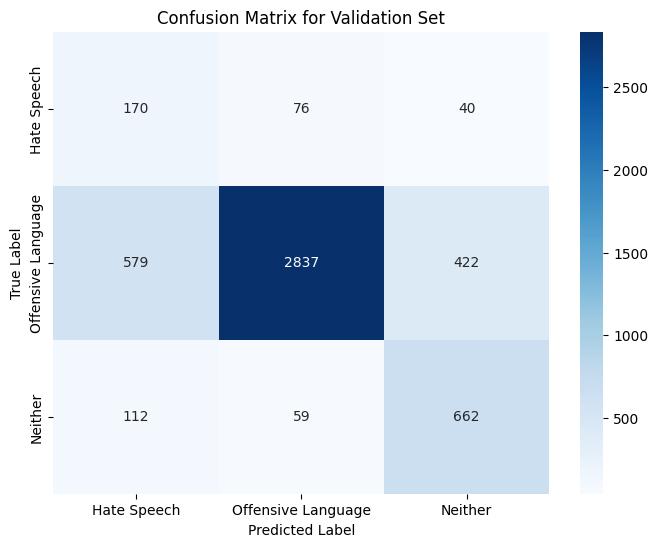

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Detailed Validation Set Evaluation ---\n")

# Get predictions for the entire validation dataset
val_predictions_probabilities = model.predict(val_dataset)
# Convert probabilities to predicted class indices
val_predicted_labels = np.argmax(val_predictions_probabilities, axis=1)

# We need the true labels from the validation dataset
# We can extract them by iterating through the dataset
true_val_labels_list = []
for _, labels_batch in val_dataset:
    true_val_labels_list.extend(labels_batch.numpy())
true_val_labels_array = np.array(true_val_labels_list)

# Ensure we have the correct number of labels (handle potential partial last batch)
val_predicted_labels = val_predicted_labels[:len(true_val_labels_array)]

# Original dataset mapping: 0: hate_speech, 1: offensive_language, 2: neither
class_names = [label_map[i] for i in sorted(label_map.keys())]

# 1. Classification Report (Precision, Recall, F1-score per class)
print("\nClassification Report:\n")
print(classification_report(true_val_labels_array, val_predicted_labels, target_names=class_names, digits=3)) # Added digits for more precision

# 2. Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(true_val_labels_array, val_predicted_labels)
print(cm)

# Optional: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

***Note: Analysis of the evaluation metrics are in the report***